# My own notes on ESMPy

Pitfalls are written in **bold**

Based on https://github.com/nawendt/esmpy-tutorial

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

import ESMF

In [2]:
ESMF.__version__

'7.1.0 beta snapshot'

In [3]:
# Turn on debug mode, not required
ESMF.Manager(debug=True)

ESMPyManager:
    local_pet = 0
    pet_count = 1
)

## Create Grid object

### Create source grid

The [API documentation]() says that "staggerloc" defaults to CENTER and "coord_sys" defaults to SPH_DEG, but it turns out that **you have to explicitly set them**, otherwise the values will still be None.

In [4]:
# incorrect initialization, missing staggerloc and coord_sys
sourcegrid = ESMF.Grid(np.array([20, 20]))

# will be None or False
print(sourcegrid._coord_sys, sourcegrid._staggerloc)

# release the memory and check if it is released
sourcegrid.destroy()
print(sourcegrid.finalized)

None [False, False, False, False]
True


In [5]:
# correct initialization
sourcegrid = ESMF.Grid(np.array([20,20]), 
                       staggerloc = ESMF.StaggerLoc.CENTER,
                       coord_sys = ESMF.CoordSys.SPH_DEG)

# now the values are correctly set
print(sourcegrid._coord_sys, sourcegrid._staggerloc)

CoordSys.SPH_DEG [True, False, False, False]


In [6]:
# they are pointers, sharing the same physical memory
source_lon = sourcegrid.get_coords(0)
source_lat = sourcegrid.get_coords(1)

In [7]:
np.isfortran(np.arange(5))

False

In [8]:
np.isfortran(source_lon)

True

Assign actual coordinate value, **the array indexing [...] cannot be omitted otherwise the variable will be overwritten**.

In [9]:
lon = np.linspace(-120, 120, 20)
lat = np.linspace(-60, 60, 20)
source_lon[...], source_lat[...] = np.meshgrid(lon, lat)

In [10]:
# make sure the changes are made in the original object.
def check_range(grid,stgloc):
    coord_center = grid.coords[stgloc]
    print(coord_center[0].min(),
          coord_center[0].max(),
          coord_center[1].min(),
          coord_center[1].max())
    
check_range(sourcegrid,0)

-120.0 120.0 -60.0 60.0


### Create destination grid in the same way

In [11]:
# 2x coarse than original grid
destgrid = ESMF.Grid(np.array([10,10]), 
                     staggerloc = ESMF.StaggerLoc.CENTER,
                     coord_sys = ESMF.CoordSys.SPH_DEG)

dest_lon = destgrid.get_coords(0)
dest_lat = destgrid.get_coords(1)

dest_lon[...], dest_lat[...] = np.meshgrid(np.linspace(-150, 170, 10),
                                           np.linspace(-80, 80, 10))
check_range(destgrid,0)

-150.0 170.0 -80.0 80.0


## Create data fields

In [12]:
sourcefield = ESMF.Field(sourcegrid, name = 'fakedata')
destfield = ESMF.Field(destgrid, name = 'fakedata')

In [13]:
# name is not too useful...
sourcefield.name

'fakedata'

In [14]:
# The grid object is hooked to the field
type(sourcefield.grid)

ESMF.api.grid.Grid

In [15]:
# data has the same shape as the grid. 
sourcefield.data.shape

(20, 20)

Assign actual data value. Again, don't overwrite the variable.

In [16]:
wave = np.sin(np.linspace(0, 2*np.pi, 20))
sourcefield.data[...] = np.outer(wave, wave)+1

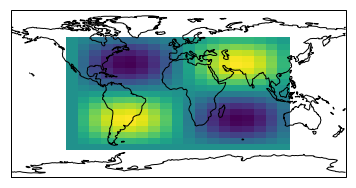

In [17]:
def plot_field(field, data=None):  
    lons = field.grid.coords[0][0]
    lats = field.grid.coords[0][1]
    if data is None:
        data = field.data
    
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.pcolormesh(lons, lats, data)
    ax.coastlines()
    ax.set_global()
    
plot_field(sourcefield)

## Regrid from source to destination

**Have to set unmapped_action to IGNORE**, otherwise an error will occur (without useful error message) if the destination grid is larger than the source grid.

BILINEAR regridding is used because only the center coordinate is available.

In [18]:
# calculate regridding weights
regrid_bi = ESMF.Regrid(sourcefield, destfield, 
                        regrid_method = ESMF.RegridMethod.BILINEAR,  
                        unmapped_action = ESMF.UnmappedAction.IGNORE)

In [19]:
# apply regridding weights
destfield = regrid_bi(sourcefield, destfield)

In [20]:
dest_lon[...], dest_lat[...] = np.meshgrid(np.linspace(-150, 170, 10),
                                           np.linspace(-80, 80, 10))

Areas out of the source grid will be zero.

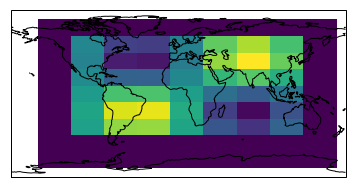

In [21]:
plot_field(destfield)

In [22]:
destfield.data

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  1.10337786,  1.62891306,  1.64942157,  1.14458964,
         0.52497097,  0.28899405,  0.62492423,  0.        ,  0.        ],
       [ 0.        ,  1.13893668,  1.84721738,  1.87939784,  1.19548573,
         0.36062589,  0.0445649 ,  0.4953743 ,  0.        ,  0.        ],
       [ 0.        ,  1.0635117 ,  1.38763999,  1.40317921,  1.08957004,
         0.70755487,  0.56326907,  0.76922618,  0.        ,  0.        ],
       [ 0.        ,  0.9364883 ,  0.61236001,  0.59682079,  0.91042996,
         1.29244513,  1.43673093,  1.23077382,  0.        ,  0.        ],
       [ 0.        ,  0.86106332,  0.15278262,  0.12060216,  0.80451427,
         1.63937411,  1.9554351 ,  1.5046257 

## Conservative regridding

### Add corner information

In [23]:
sourcegrid.add_coords(staggerloc = ESMF.StaggerLoc.CORNER_VCENTER)

source_lat_b = sourcegrid.get_coords(coord_dim = 1, 
                                     staggerloc = ESMF.StaggerLoc.CORNER)
source_lon_b = sourcegrid.get_coords(coord_dim = 0, 
                                     staggerloc = ESMF.StaggerLoc.CORNER)


destgrid.add_coords(staggerloc = ESMF.StaggerLoc.CORNER_VCENTER)

dest_lat_b = destgrid.get_coords(coord_dim = 1, 
                              staggerloc = ESMF.StaggerLoc.CORNER)
dest_lon_b = destgrid.get_coords(coord_dim = 0, 
                              staggerloc = ESMF.StaggerLoc.CORNER)

The shape is N+1

In [24]:
print(source_lat_b.shape,dest_lat_b.shape)

(21, 21) (11, 11)


Assign fake values (not matching the previous center info)

In [25]:
source_lon_b[...], source_lat_b[...] = np.meshgrid(np.linspace(-120, 120, 21),
                                                   np.linspace(-60, 60, 21))

dest_lon_b[...], dest_lat_b[...] = np.meshgrid(np.linspace(-150, 170, 11),
                                           np.linspace(-80, 80, 11))

In [26]:
check_range(sourcegrid,3);check_range(destgrid,3)

-120.0 120.0 -60.0 60.0
-150.0 170.0 -80.0 80.0


The area is still not known, not matching the API documentation that it will be calculated

In [27]:
sourcegrid.area

[None, None, None, None]

ESMF.Regrid requires field as input, not grid. (why?)

In [28]:
# ndbounds allows for extra dimensions
sourcefield2 = ESMF.Field(sourcegrid, name = 'fakedata2',ndbounds=[5,2])
destfield2 = ESMF.Field(destgrid, name = 'fakedata2',ndbounds=[5,2])
sourcefield2.data.shape

(20, 20, 5, 2)

**The additional dimension is Fortran-like, Not C-like. Will this affect performance?**

In [29]:
# assign data values
sourcefield2.data[...] = sourcefield.data[:,:,np.newaxis,np.newaxis]

In [30]:
# calculate regridding weights
regrid_con = ESMF.Regrid(sourcefield2, destfield2, 
                         regrid_method = ESMF.RegridMethod.CONSERVE,  
                         unmapped_action = ESMF.UnmappedAction.IGNORE)

In [31]:
destfield2 = regrid_con(sourcefield2, destfield2)

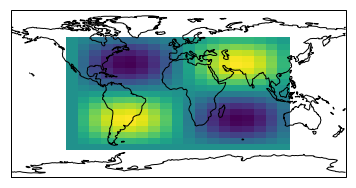

In [32]:
plot_field(sourcefield2,sourcefield2.data[:,:,0,0])

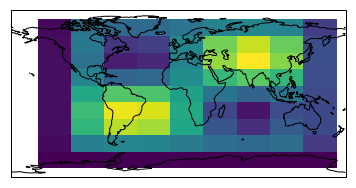

In [33]:
plot_field(destfield2,destfield2.data[:,:,0,0])